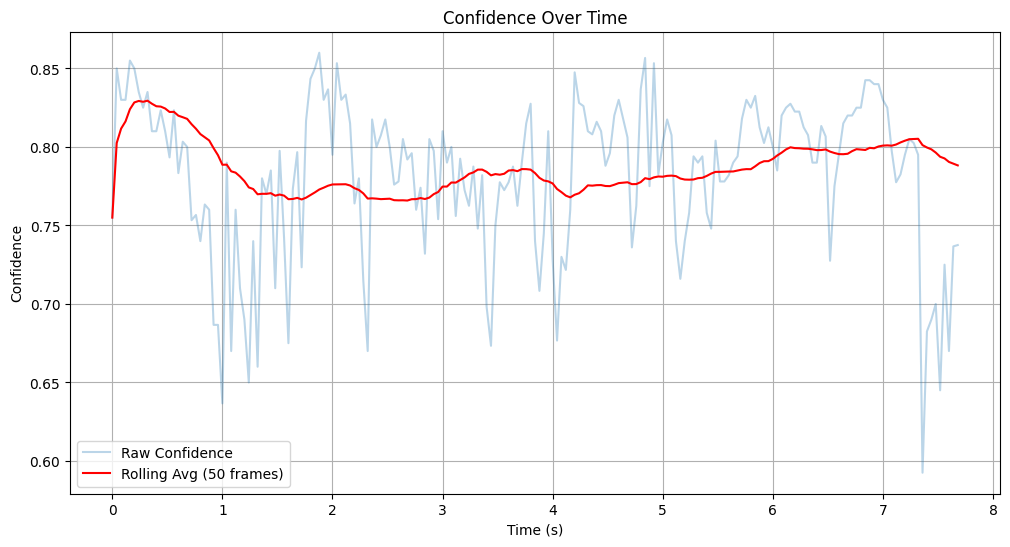

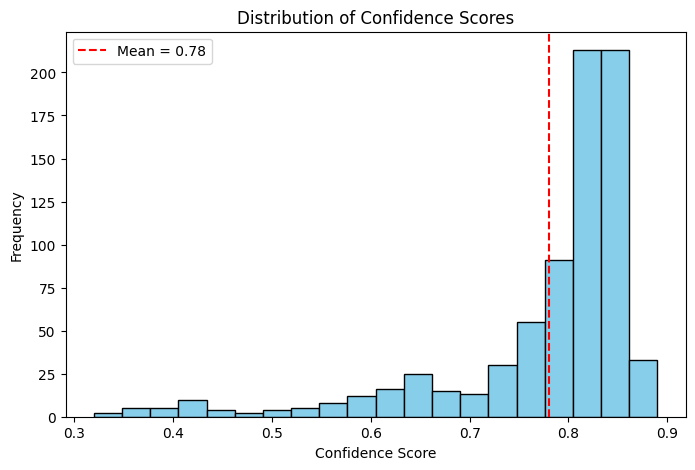

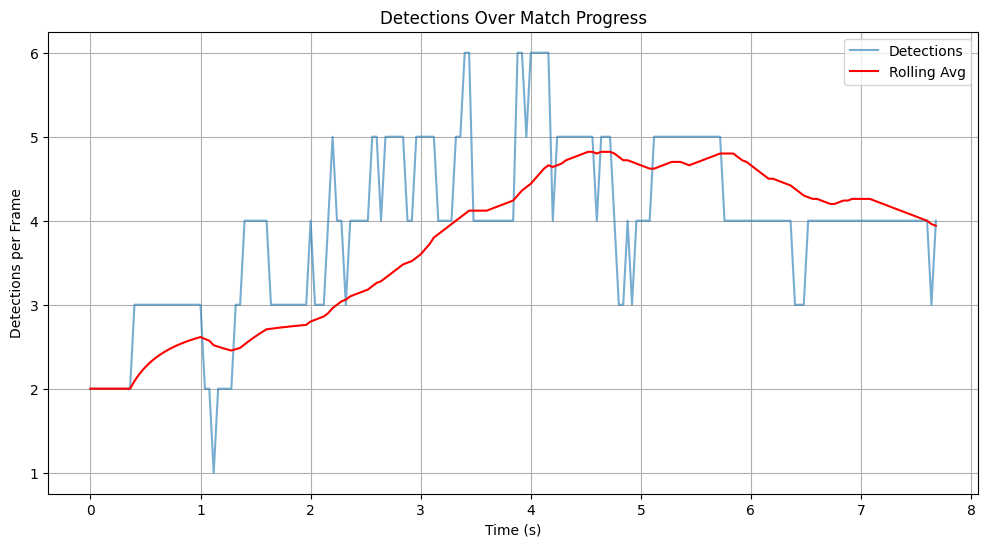

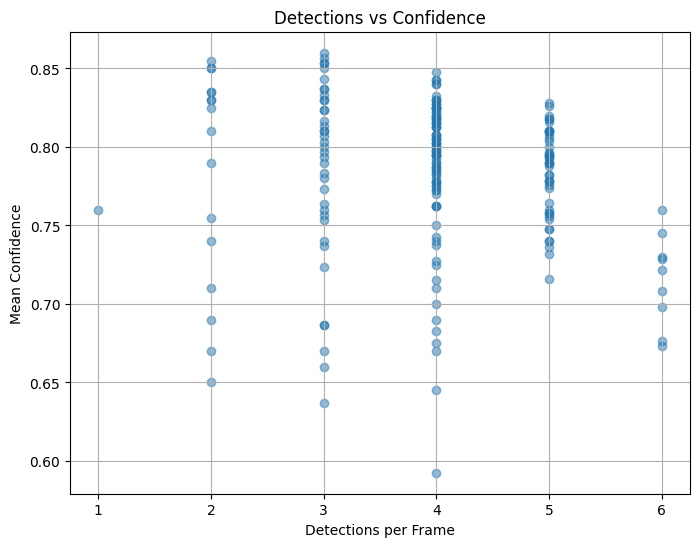

<Figure size 1000x600 with 0 Axes>

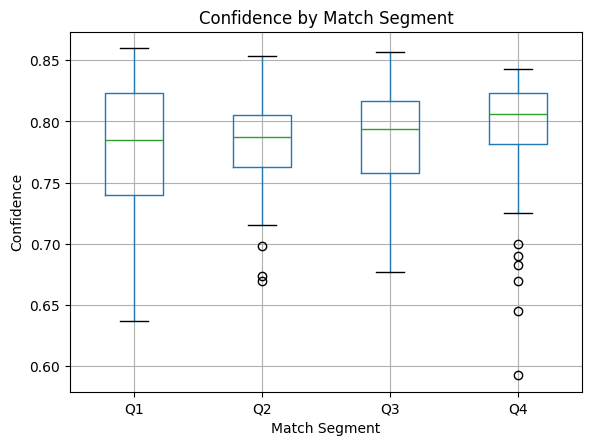

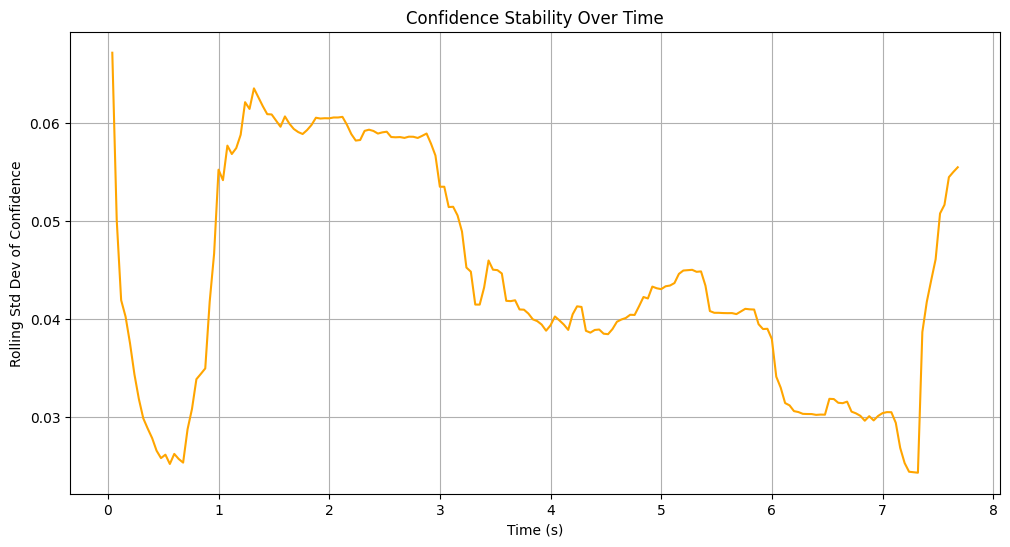

=== Summary Stats ===
Mean confidence: 0.780
Median confidence: 0.820
Low confidence frames (<0.7): 17 / 193
Average detections per frame: 3.94


In [6]:
# ===============================================
# Model Accuracy Pipeline
# ===============================================
# Usage:
#   1. Place your CSV (ground truth/reference) and JSON (model predictions) in the working directory.
#   2. Call run_pipeline("tracking_csv.csv", "tracking_results.json")
#   3. The pipeline will load data, compute metrics, and generate charts.
# ===============================================

import json
import pandas as pd
import matplotlib.pyplot as plt

def load_data(csv_path, json_path):
    """Load CSV and JSON into DataFrames."""
    csv_df = pd.read_csv(csv_path)

    with open(json_path, "r") as f:
        tracking_data = json.load(f)

    records = []
    for frame in tracking_data["tracking_results"]:
        ts = frame["timestamp"]
        frame_no = frame["frame_number"]
        for p in frame["players"]:
            records.append({
                "frame": frame_no,
                "timestamp": ts,
                "player_id": p["player_id"],
                "confidence": p["confidence"],
                "width": p["bbox"]["x2"] - p["bbox"]["x1"],
                "height": p["bbox"]["y2"] - p["bbox"]["y1"]
            })
    df = pd.DataFrame(records)
    return csv_df, df


def compute_metrics(df, threshold=0.7):
    """Aggregate key metrics per frame."""
    metrics = df.groupby(["frame", "timestamp"]).agg(
        mean_conf=("confidence", "mean"),
        det_count=("player_id", "count"),
        bbox_var=("width", "std")
    ).reset_index()

    metrics["low_conf"] = metrics["mean_conf"] < threshold
    metrics["conf_smooth"] = metrics["mean_conf"].rolling(window=20, min_periods=1).mean()
    metrics["rolling_conf"] = metrics["mean_conf"].rolling(window=50, min_periods=1).mean()
    metrics["det_count_smooth"] = metrics["det_count"].rolling(window=50, min_periods=1).mean()
    metrics["time_bin"] = pd.cut(metrics["timestamp"], bins=4, labels=["Q1","Q2","Q3","Q4"])
    metrics["conf_std"] = metrics["mean_conf"].rolling(window=50, min_periods=1).std()
    return metrics


def plot_metrics(metrics, df):
    """Generate important charts and stats."""

    # Confidence over time
    plt.figure(figsize=(12,6))
    plt.plot(metrics["timestamp"], metrics["mean_conf"], alpha=0.3, label="Raw Confidence")
    plt.plot(metrics["timestamp"], metrics["rolling_conf"], color="red", label="Rolling Avg (50 frames)")
    plt.xlabel("Time (s)")
    plt.ylabel("Confidence")
    plt.title("Confidence Over Time")
    plt.legend(); plt.grid(); plt.show()

    # Distribution of confidence
    plt.figure(figsize=(8,5))
    plt.hist(df["confidence"], bins=20, color="skyblue", edgecolor="black")
    plt.axvline(df["confidence"].mean(), color="red", linestyle="--", label=f"Mean = {df['confidence'].mean():.2f}")
    plt.xlabel("Confidence Score"); plt.ylabel("Frequency")
    plt.title("Distribution of Confidence Scores"); plt.legend(); plt.show()

    # Detections per frame
    plt.figure(figsize=(12,6))
    plt.plot(metrics["timestamp"], metrics["det_count"], alpha=0.6, label="Detections")
    plt.plot(metrics["timestamp"], metrics["det_count_smooth"], color="red", label="Rolling Avg")
    plt.xlabel("Time (s)"); plt.ylabel("Detections per Frame")
    plt.title("Detections Over Match Progress"); plt.legend(); plt.grid(); plt.show()

    # Scatter plot (detections vs confidence)
    plt.figure(figsize=(8,6))
    plt.scatter(metrics["det_count"], metrics["mean_conf"], alpha=0.5)
    plt.xlabel("Detections per Frame"); plt.ylabel("Mean Confidence")
    plt.title("Detections vs Confidence"); plt.grid(); plt.show()

    # Confidence by match segment
    plt.figure(figsize=(10,6))
    metrics.boxplot(column="mean_conf", by="time_bin")
    plt.xlabel("Match Segment"); plt.ylabel("Confidence")
    plt.title("Confidence by Match Segment"); plt.suptitle(""); plt.show()

    # Stability of confidence
    plt.figure(figsize=(12,6))
    plt.plot(metrics["timestamp"], metrics["conf_std"], color="orange")
    plt.xlabel("Time (s)"); plt.ylabel("Rolling Std Dev of Confidence")
    plt.title("Confidence Stability Over Time"); plt.grid(); plt.show()

    # Print summary stats
    print("=== Summary Stats ===")
    print(f"Mean confidence: {df['confidence'].mean():.3f}")
    print(f"Median confidence: {df['confidence'].median():.3f}")
    print(f"Low confidence frames (<0.7): {metrics['low_conf'].sum()} / {len(metrics)}")
    print(f"Average detections per frame: {metrics['det_count'].mean():.2f}")


def run_pipeline(csv_path, json_path):
    csv_df, df = load_data(csv_path, json_path)
    metrics = compute_metrics(df)
    plot_metrics(metrics, df)


# Example usage:
run_pipeline("tracking_csv.csv", "tracking_results.json")
